In [1]:
import ROOT as r
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import pickle
import spliland
import importlib
import random
import fclParse
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

Welcome to JupyROOT 6.18/04


In [2]:
directory = './template_data/set_7/'

In [3]:
tf.config.run_functions_eagerly(True)

## Intro

The purpose of this notebook is to make a second attempt at a neural network, following along with what was described in the paper "Deep Learning Based Pulse Shape Analysis for GERDA" by Philipp Holl in 2017. This algorithm consists of an autoencoder, decoder, and then classifier.

I am also following this guide: https://keras.io/examples/timeseries/timeseries_anomaly_detection/ for the implementation of the layers described in the paper into python

### Prep the data

In [4]:
n_points = 8000

with open(directory + 'x_train.data', 'rb') as xFile:
    biggestX = pickle.load(xFile)
    x_train = []
    for x in biggestX[:n_points]:
        x_train.append(x[1])
    xFile.close()
    
with open(directory + 'x_test.data', 'rb') as xFile:
    biggestX = pickle.load(xFile)
    x_test = []
    for x in biggestX[:2000]:
        x_test.append(x[1])
    xFile.close()

with open(directory + 'y_train.data', 'rb') as yFile:
    biggestY = pickle.load(yFile)
    y_train = biggestY[:n_points]
    yFile.close()
    
with open(directory + 'y_test.data', 'rb') as yFile:
    biggestY = pickle.load(yFile)
    y_test = biggestY[:2000]
    yFile.close()
    
with open(directory + 'x_delta_train.data', 'rb') as xFile:
    biggestX = pickle.load(xFile)
    x_delta_train = []
    for x in biggestX[:n_points]:
        x_delta_train.append(x[1])
    xFile.close()
    
with open(directory + 'x_delta_test.data', 'rb') as xFile:
    biggestX = pickle.load(xFile)
    x_delta_test = []
    for x in biggestX[:2000]:
        x_delta_test.append(x[1])
    xFile.close()
    
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_delta_train = np.array(x_delta_train)
x_delta_test = np.array(x_delta_test)

In [5]:
X_train = np.reshape(x_train, (n_points, 404, 1))
X_delta_train = np.reshape(x_delta_train, (n_points, 404, 1))

In [6]:
X_train.shape

(8000, 404, 1)

In [7]:
Y_train = np.reshape(y_train, (n_points, 1))

### Autoencoder
As described in the paper, this step consists of a convolutional layer, followed by a fully connected layer to create a feature vector. In keras, a fully connected layer is called a dense layer

In [14]:
encoder_model = keras.Sequential([
    keras.layers.Input(shape=(x_train.shape[1], 1)),
    # encoding
    keras.layers.Conv1D(filters=1, kernel_size=9, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Dense(50, activation='relu'),

    # decoding
    keras.layers.Dense(50, activation='relu'),
    keras.layers.UpSampling1D(size=4),
    keras.layers.Conv1DTranspose(filters=1, kernel_size=9, activation='relu')
])

In [15]:
encoder_model.compile(optimizer = 'adam', loss='mse')

In [16]:
history = encoder_model.fit(X_train, X_train, epochs=50,
                            batch_size=128, validation_split=0.2)

Epoch 1/50
50/50 [==============================] - 2s 38ms/step - loss: 1.7159e-04 - val_loss: 1.1684e-04
Epoch 2/50
50/50 [==============================] - 2s 38ms/step - loss: 5.8130e-05 - val_loss: 5.6898e-05
Epoch 3/50
50/50 [==============================] - 2s 38ms/step - loss: 3.8168e-05 - val_loss: 4.3546e-05
Epoch 4/50
50/50 [==============================] - 2s 38ms/step - loss: 2.9442e-05 - val_loss: 3.6056e-05
Epoch 5/50
50/50 [==============================] - 2s 38ms/step - loss: 2.5543e-05 - val_loss: 3.3072e-05
Epoch 6/50
50/50 [==============================] - 2s 39ms/step - loss: 2.3768e-05 - val_loss: 3.1077e-05
Epoch 7/50
50/50 [==============================] - 2s 38ms/step - loss: 2.2352e-05 - val_loss: 2.9658e-05
Epoch 8/50
50/50 [==============================] - 2s 39ms/step - loss: 2.1275e-05 - val_loss: 2.8430e-05
Epoch 9/50
50/50 [==============================] - 2s 39ms/step - loss: 2.0359e-05 - val_loss: 2.7613e-05
Epoch 10/50
50/50 [==================

In [17]:
x_train_pred = encoder_model.predict(X_train)

In [18]:
x_train_pred.shape

(8000, 404, 1)

511
4


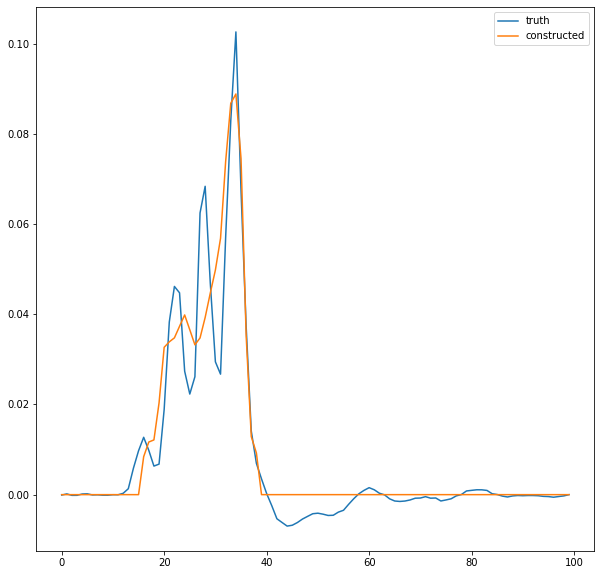

In [22]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,10)

num = np.random.randint(low=0, high=n_points)
print(num)

print(y_train[num])

ax.plot(x_train[num][:100], label='truth')
#ax.plot(x_delta_train[num][:100], label='target')
ax.plot(x_train_pred[num][:100], label='constructed')

plt.legend(loc=0)

### Classifier

In [31]:
classifier_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(404,)),
    keras.layers.Dense(10, activation='relu')
])

In [32]:
classifier_model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [33]:
X_train_pred = x_train_pred.reshape(n_points, 404)
print(X_train_pred.shape)
print(Y_train.shape)

(8000, 404)
(8000, 1)


In [34]:
classifier_history = classifier_model.fit(X_train_pred,
                                          Y_train,
                                          epochs=50)

Epoch 1/50
250/250 [==============================] - 2s 7ms/step - loss: 2.1024 - accuracy: 0.2370
Epoch 2/50
250/250 [==============================] - 2s 7ms/step - loss: 1.9203 - accuracy: 0.3284
Epoch 3/50
250/250 [==============================] - 2s 7ms/step - loss: 1.7945 - accuracy: 0.3701
Epoch 4/50
250/250 [==============================] - 2s 7ms/step - loss: 1.7086 - accuracy: 0.3938
Epoch 5/50
250/250 [==============================] - 2s 7ms/step - loss: 1.6547 - accuracy: 0.4141
Epoch 6/50
250/250 [==============================] - 2s 7ms/step - loss: 1.6158 - accuracy: 0.4317
Epoch 7/50
250/250 [==============================] - 2s 7ms/step - loss: 1.5844 - accuracy: 0.4478
Epoch 8/50
250/250 [==============================] - 2s 7ms/step - loss: 1.5600 - accuracy: 0.4601
Epoch 9/50
250/250 [==============================] - 2s 7ms/step - loss: 1.5399 - accuracy: 0.4645
Epoch 10/50
250/250 [==============================] - 2s 8ms/step - loss: 1.5215 - accuracy: 0.4770

In [35]:
classifier_model_2 = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(404,)),
    keras.layers.Dense(10, activation='relu')
])

classifier_model_2.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [37]:
classifier_history_2 = classifier_model_2.fit(x_train,
                                            Y_train,
                                            epochs=50)

Epoch 1/50
250/250 [==============================] - 2s 7ms/step - loss: 1.7937 - accuracy: 0.3841
Epoch 2/50
250/250 [==============================] - 2s 7ms/step - loss: 1.7104 - accuracy: 0.4002
Epoch 3/50
250/250 [==============================] - 2s 8ms/step - loss: 1.6622 - accuracy: 0.4169
Epoch 4/50
250/250 [==============================] - 2s 8ms/step - loss: 1.6260 - accuracy: 0.4366
Epoch 5/50
250/250 [==============================] - 2s 8ms/step - loss: 1.5966 - accuracy: 0.4501
Epoch 6/50
250/250 [==============================] - 2s 8ms/step - loss: 1.5718 - accuracy: 0.4590
Epoch 7/50
250/250 [==============================] - 2s 8ms/step - loss: 1.5497 - accuracy: 0.4691
Epoch 8/50
250/250 [==============================] - 2s 8ms/step - loss: 1.5303 - accuracy: 0.4781
Epoch 9/50
250/250 [==============================] - 2s 8ms/step - loss: 1.5130 - accuracy: 0.4848
Epoch 10/50
250/250 [==============================] - 2s 8ms/step - loss: 1.4977 - accuracy: 0.4910

### Performance Stats

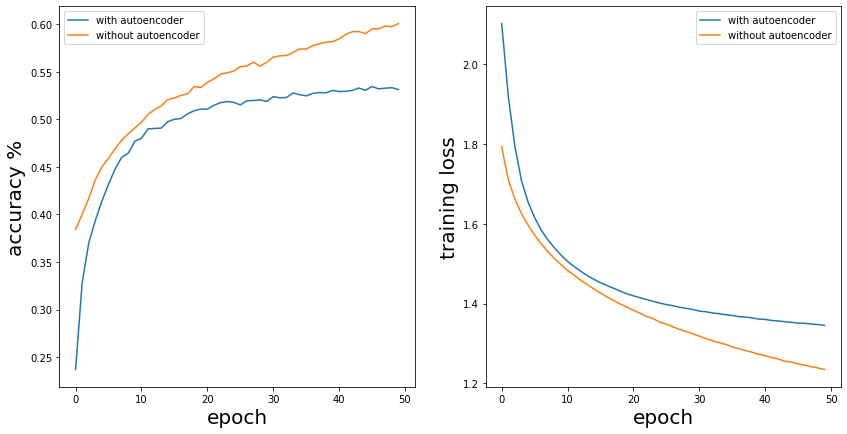

In [38]:
fig, ax = plt.subplots(1,2);
fig.set_size_inches(14,7);

ax[0].plot(classifier_history.history['accuracy'], label='with autoencoder')
ax[0].plot(classifier_history_2.history['accuracy'], label='without autoencoder')

ax[0].set_xlabel("epoch", fontsize=20)
ax[0].set_ylabel("accuracy %", fontsize=20)
ax[0].legend()

ax[1].plot(classifier_history.history['loss'], label='with autoencoder')
ax[1].plot(classifier_history_2.history['loss'], label='without autoencoder')

ax[1].set_xlabel("epoch", fontsize=20)
ax[1].set_ylabel("training loss", fontsize=20)
ax[1].legend()

In [41]:
Y_pred = classifier_model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

matrix = confusion_matrix(y_test, y_pred, normalize='true', labels=[1,2,3,4,5,6])


Y_pred_2 = classifier_model_2.predict(x_test)
y_pred_2 = np.argmax(Y_pred_2, axis=1)

matrix_2 = confusion_matrix(y_test, y_pred_2, normalize='true', labels=[1,2,3,4,5,6])


Text(0.5, 1.0, 'without autoencoder')

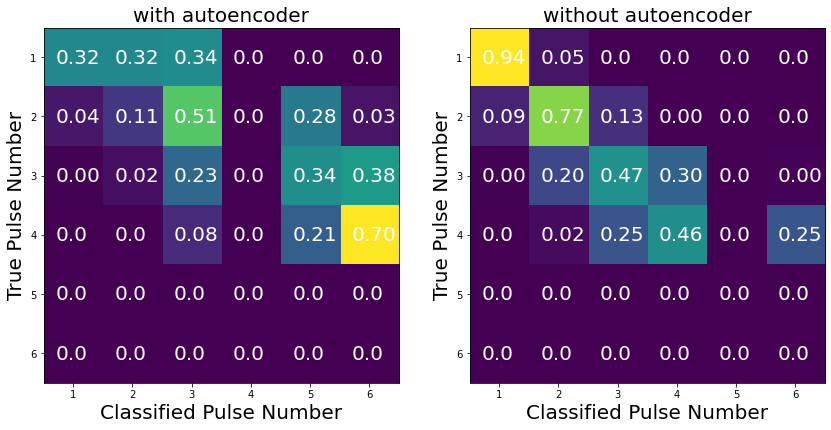

In [42]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14,7)

labels = ['1', '2', '3', '4', '5', '6']

grid = np.array(matrix)
im = ax[0].imshow(grid)

for k in range (0, len(grid)):
        for l in range (0, len(grid[0])):
            ax[0].text(l-0.3, k+0.1, str(grid[k][l])[:4], size=20, color='white')
            
ax[0].set_xticklabels([''] + labels);
ax[0].set_yticklabels([''] + labels);

ax[0].set_ylabel('True Pulse Number', fontsize=20);
ax[0].set_xlabel('Classified Pulse Number', fontsize=20);

ax[0].set_title("with autoencoder", fontsize=20)


grid = np.array(matrix_2)
im = ax[1].imshow(grid)

for k in range (0, len(grid)):
        for l in range (0, len(grid[0])):
            ax[1].text(l-0.3, k+0.1, str(grid[k][l])[:4], size=20, color='white')
            
ax[1].set_xticklabels([''] + labels);
ax[1].set_yticklabels([''] + labels);

ax[1].set_ylabel('True Pulse Number', fontsize=20);
ax[1].set_xlabel('Classified Pulse Number', fontsize=20);

ax[1].set_title("without autoencoder", fontsize=20)
